In [1]:
import glob
from collections import defaultdict
from itertools import product

import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import umap.umap_ as umap  # NOTE: must install umap-learn not umap
from networkx.drawing.nx_agraph import graphviz_layout
from scipy.cluster.hierarchy import leaves_list, linkage
from scipy.spatial.distance import pdist, squareform
from scripts import aesthetics, tree
from scripts import manuscript_colors as mc
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import colors
import palettable

aesthetics.activate_paper_rcParams('illustrator')


import warnings

warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [2]:
import prince

# Make Tree Figures

This is just a replicate of `examine-category-hierarchies`, but that notebook was getting to be a bit too complicated.

## Read in data

In [3]:
###########
### SVs ###
###########
category_svs = []
for file in glob.glob("data/CWAS data for Jett/List of variants by category/*.txt"):
    disease = file.split("/")[-1].split("_")[0]

    if disease == "osteosarcoma":
        continue

    sv_category = "noncoding" if "noncoding" in file else "coding"

    cat_svs = pd.read_csv(file, sep="\t").rename(columns={"emd": "end"})
    cat_svs[["disease", "sv_category"]] = [disease, sv_category]
    category_svs.append(cat_svs)

category_svs = pd.concat(category_svs)
category_svs.head(2)

,SV,chrom,start,end,category,disease,sv_category
0,PedSV.2.5.2_DUP_chr1_455,chr1,6720524,6722070,DUP.RARE.PREDICTED_NONCODING_BREAKPOINT.ewing_...,ewing,noncoding
1,PedSV.2.5.2_DUP_chr1_898,chr1,23649481,23651544,DUP.RARE.PREDICTED_NONCODING_BREAKPOINT.ewing_...,ewing,noncoding


In [4]:
category_svs["value"] = 1

In [5]:
#########################
### FRAMEWORK RESULTS ###
#########################
framework_results = []
for file in glob.glob("data/CWAS data for Jett/CWAS sum stats/*.txt"):
    if "12_26_23" not in file:
        continue

    disease = file.split("/")[-1].split("_")[0]

    if disease == "osteosarcoma":
        continue

    sv_category = "noncoding" if "noncoding" in file else "coding"
    af_category = "singleton" if "SINGLETON" in file else "rare"

    data = pd.read_csv(file, sep="\t")
    data[["disease", "sv_category", "af_category"]] = [
        disease,
        sv_category,
        af_category,
    ]
    framework_results.append(data)

framework_results = pd.concat(framework_results)

In [6]:
len(framework_results.columns)

23

We have some new summary stats for the noncoding analysis

In [7]:
# drop all noncoding results, as these are now here
framework_results = framework_results.query('sv_category == "coding"')

In [8]:
for new_file in glob.glob('data/CWAS data for Jett/CWAS sum stats adjusted/*.txt'):
    disease = new_file.split("/")[-1].split("_")[0]
    
    data = pd.read_csv(new_file, sep='\t')
    data[["disease", "sv_category"]] = [
        disease,
        "noncoding"
    ]
    
    data['af_category'] = data['category_name'].apply(lambda c: 'rare' if '.RARE.' in c else 'singleton')
    data['frequency'] = data['af_category'].apply(lambda c: c.upper())
    
    framework_results = pd.concat([framework_results, data])

In [9]:
# for thing in framework_results.query('disease == "ewing" & sv_category == "coding" & bonferroni_significant')['category_name']:
#     print(thing)

Add some data to the framework results

In [10]:
framework_results["functional_category"] = framework_results["category_name"].apply(
    lambda c: c.split(".")[3] if len(c.split(".")) == 8 else np.nan
)

In [11]:
category_sizes = (
    category_svs.groupby(["category", "disease", "sv_category"])["value"]
    .sum()
    .reset_index()
    .rename(columns={"category": "category_name", "value": "num_svs_in_cat"})
)
framework_results = framework_results.merge(
    category_sizes, on=["category_name", "disease", "sv_category"], how="left"
)

## Filter the framework results a tad and add bonferroni

None of the gene groups are significant, and they significantly increase the size of the dataset, so I'm going to drop them.

In [12]:
p_val_cutoffs = {
    "neuroblastoma_coding": 0.05 / 279,
    "neuroblastoma_noncoding": 0.05 / 940,
    "ewing_coding": 0.05 / 267,
    "ewing_noncoding": 0.05 / 916,
}

framework_results["bonferroni_significant"] = framework_results.apply(
    lambda row: row["p_value"]
    < p_val_cutoffs[row["disease"] + "_" + row["sv_category"]],
    axis=1,
)

In [13]:
master_framework_results = framework_results.copy().set_index('category_name')

# subset to only protein coding categories
framework_results = framework_results[
    framework_results["category_name"].str.contains("protein_coding")
].copy()

In [14]:
framework_schema = defaultdict(dict)
for file in glob.glob("data/CWAS data for Jett/CWAS frameworks/*.txt"):
    if "osteosarcoma" in file:
        continue

    disease = "neuroblastoma" if "neuroblastoma" in file else "ewing"
    sv_category = "noncoding" if "noncoding" in file else "coding"

    data = pd.read_csv(file, sep="\t")
    framework_schema[f"{disease}_{sv_category}"] = data

In [15]:
framework_schema['ewing_noncoding']

,sv_type,frequency,functional_intersection,functional_category,genic_relationship,constraint,expression,gene_group
0,DUP,RARE,PREDICTED_NONCODING_BREAKPOINT,ewing_and_osteosarcoma_atac_peaks,PREDICTED_INTERGENIC,lof_constrained,expressed_in_muscle_skeletal,protein_coding
1,DEL,SINGLETON,PREDICTED_NONCODING_SPAN,ewing_chromHMM15_EnhBiv,PREDICTED_INTRONIC,ANY,ANY,cosmic_and_germline_CPGs
2,CPX_or_INV,NaN,ANY,ewing_H3K27Ac_peak,PREDICTED_PROMOTER,NaN,NaN,NaN
3,INS_ALL,NaN,NaN,ewing_ABC_MAX_enhancer,PREDICTED_UTR,NaN,NaN,NaN
4,ANY,NaN,NaN,ewing_chromHMM15_Enh,ANY,NaN,NaN,NaN
5,NaN,NaN,NaN,ewing_chromHMM15_TssAFlnk,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,ewing_and_osteosarcoma_atac_peaks_conserved,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,ewing_and_osteosarcoma_tad_boundary,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,ewing_chromHMM15_EnhBiv_conserved,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,ewing_chromHMM15_TssAFlnk_conserved,NaN,NaN,NaN,NaN


# Define the parent-child structure

In [16]:
parent_dicts = {
    "coding": {
        "sv_type": "ANY",
        "frequency": "RARE",
        "genic_relationship": "ANY",
        "constraint": "ANY",
        "expression": "ANY",
        "gene_group": "protein_coding",
    },
    "noncoding": {
        "sv_type": "ANY",
        "frequency": "RARE",
        "functional_intersection": "ANY",
        "functional_category": "",
        "genic_relationship": "ANY",
        "constraint": "ANY",
        "expression": "ANY",
        "gene_group": "protein_coding",
    },
}

In [17]:
trees_to_make = [('neuroblastoma', 'coding'), 
                 ('ewing', 'coding'), 
                 ('neuroblastoma', 'noncoding', 'neuroblastoma_tad_boundary')]

We also define some things here for plotting

In [18]:
norm_coding = [0.20, 0.55]
norm_noncoding = [0.20, 0.55]

In [19]:
np.exp(0.20), np.exp(0.55), np.exp(0.25), np.exp(0.60)

(1.2214027581601699,
 1.7332530178673953,
 1.2840254166877414,
 1.8221188003905089)

In [20]:
2**0.20, 2**0.55

(1.148698354997035, 1.4640856959456254)

In [21]:
palette = {'neuroblastoma': mc.palette['neuroblastoma']["main"],
           'ewing': mc.palette['ewing']["main"]}

# Establish the paths

In [22]:
label_dict = {
    "neuroblastoma | coding": [
        "ANY.SINGLETON.ANY.ANY.ANY.protein_coding",
        "ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding",
        "ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding",
        "DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding",
        "DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.lof_constrained.expressed_in_adrenal_gland.protein_coding"
    ],
    
    "ewing | coding": [
        "ANY.SINGLETON.ANY.ANY.ANY.protein_coding",
        "ANY.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding",
        "ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_muscle_skeletal.protein_coding",
        "DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_muscle_skeletal.protein_coding",
        "DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.lof_constrained.expressed_in_muscle_skeletal.protein_coding"
    ],
    "neuroblastoma | noncoding | neuroblastoma_tad_boundary":
        [
            "ANY.SINGLETON.ANY.neuroblastoma_tad_boundary.ANY.ANY.ANY.protein_coding",
            "ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.ANY.ANY.ANY.protein_coding",
            "ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.ANY.ANY.protein_coding",
            "ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.ANY.expressed_in_adrenal_gland.protein_coding",
            "DEL.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.ANY.expressed_in_adrenal_gland.protein_coding",
        ],
}

for label, path in label_dict.items():
    for p in path:
        assert p in list(framework_results['category_name'])

In [23]:
palette = {'neuroblastoma': {'control': 'lightgrey', 
                             'case': mc.palette['neuroblastoma']['light2'],
                             'case_unique': mc.palette['neuroblastoma']['main']},
           'ewing': {'control': 'lightgrey', 
                     'case': mc.palette['ewing']['light2'],
                     'case_unique': mc.palette['ewing']['main']}
          }

# Make the trees

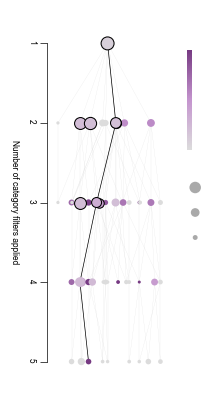

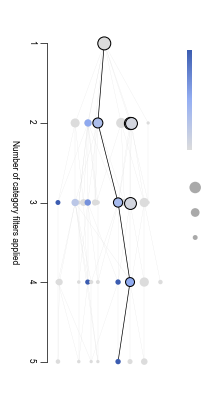

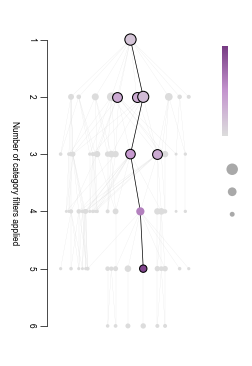

In [24]:
node_dfs = []
for t in trees_to_make:
    
    disease, sv_category = t[0], t[1]

    subframework_results = framework_results.query(
        f'disease == "{disease}" & sv_category == "{sv_category}" & af_category == "singleton"'
    )

    if sv_category == "noncoding":
        func_cat = t[2]

        subframework_results = subframework_results.query(
            f'functional_category == "{func_cat}"'
        )
        
    tree_title = f'{disease} | {sv_category}'
    if sv_category == "noncoding":
        tree_title += f' | {func_cat}'
    
    path = label_dict[tree_title]

    # remove nodes with negative point estimates
    if sv_category == "coding":
        subframework_results = subframework_results.query("point_estimate > 0")

    categories = subframework_results["category_name"].tolist()

    ###########################################
    ### DEFINE DISTANCES BETWEEN CATEGORIES ###
    ###########################################

    data = category_svs[
        (category_svs["disease"] == disease)
        & (category_svs["category"].isin(categories))
        & (category_svs["sv_category"] == sv_category)
    ]

    data = data.pivot(columns="SV", index="category", values="value").fillna(0)
    data_values = data.values.astype(bool)

    j_dist = pdist(data_values, metric="jaccard")
    j_dist = 1 - squareform(j_dist)

    j_dist = pd.DataFrame(j_dist, index=data.index, columns=data.index)

    #########################################
    ### DEFINE THE CATEGORY RELATIONSHIPS ###
    #########################################

    dg = nx.DiGraph()
    p_dict = parent_dicts[sv_category]

    for i, cat_i in enumerate(categories):
        for j, cat_j in enumerate(categories):
            parent_rel = tree.classify_relationship(cat_i, cat_j, p_dict)

            if parent_rel and cat_i != cat_j:
                dg.add_edge(cat_i, cat_j, weight=j_dist.loc[cat_i, cat_j])

    # do transitive reduction - ie removes "superparent" relationships
    dg = nx.transitive_reduction(dg)

    ################################
    ### DETERMINE NODE POSITIONS ###
    ################################

    node_df = subframework_results.set_index("category_name").loc[list(dg.nodes)]

    # determine initial node positions based on hierarchy
    node_positions = graphviz_layout(
        dg, prog="dot", args="-start=42"
    )

    # redetermine node positions based on force
    force_positions = nx.spring_layout(dg, pos=node_positions, seed=42)

    # reset the x position depending category similarity.
    for cat, pos in node_positions.items():
        pos = (force_positions[cat][0], pos[1])
        node_positions[cat] = pos

    # if we're on neuroblastoma tad boundaries, edit some points
    # if sv_category == "noncoding":
    #     for cat, pos in node_positions.items():
    #         if pos[0] > 0.5:
    #             node_positions[cat] = [pos[0] - 0.15, pos[1]]

    # before we trim or tighten the tree, store it for future reference
    master_node_df = node_df.copy()
    master_node_df[["x", "y"]] = [node_positions[cat] for cat in master_node_df.index]

    #######################################
    ### TRIM TREE BY JACCARD SIMILARITY ###
    #######################################

    bonf_cats = list(node_df.query("bonferroni_significant").index) + path
    
    cutoff = 0.4 if sv_category == "coding" else 0.5
    
    dg, node_positions = tree.trim_tree_by_similarities(
        dg, node_df, node_positions, bonf_cats, j_dist, cutoff, "negative_log10_p_value", axis = 'y'
    )

    # remove nodes from our data based on this process
    kept_nodes = list(dg.nodes)
    node_df = node_df.loc[kept_nodes]

    #########################
    ### TIGHTEN THE GRAPH ###
    #########################

    dg, node_positions = tree.tighten_tree(
        dg, node_df, node_positions, 0.02, "negative_log10_p_value", axis = 'x'
    )

    # drop to these nodes and recreate positions
    kept_nodes = list(dg.nodes)
    node_df = node_df.loc[kept_nodes]

    ############################################
    ### DETERMINE OTHER NODE CHARACTERISTICS ###
    ############################################

    # and determine node size
    node_size = np.sqrt(node_df["num_svs_in_cat"])
    node_eff = node_df["point_estimate"]

    # make node colors
    norm = norm_coding if sv_category == "coding" else norm_noncoding
    norm = mpl.colors.Normalize(
        vmin=norm[0],
        vmax=norm[1],
    )
    
    custom_cmap = colors.LinearSegmentedColormap.from_list('custom', ['gainsboro', mc.palette[disease]['light2'], mc.palette[disease]['dark1']], N = 256)

    node_colors = []
    border_sizes = []
    for i in range(len(node_eff)):
        eff = node_eff.iloc[i]
        bonf = node_df["bonferroni_significant"].iloc[i]
        pval = node_df["p_value"].iloc[i]
        
        if pval > 0.05:
            node_colors.append("gainsboro")
        else:
            node_colors.append(custom_cmap(norm(eff)))

        # # determine the border size
        if bonf:
            border_sizes.append(0.75)
        else:
            border_sizes.append(0)

    node_colors = pd.Series(node_colors, index=node_df.index)
    border_sizes = pd.Series(border_sizes, index=node_df.index)

    #####################
    ### PLOT THE TREE ###
    #####################

    if sv_category == "coding":
        fig, ax = plt.subplots(1, 1, figsize=(1.6, 5), tight_layout=False)
    else:
        fig, ax = plt.subplots(1, 1, figsize=(2.0, 4.5), tight_layout=False)

    # create a variable for plotting level
    node_df["plot_level"] = 0
    sorted_sig_cats = node_df.query("bonferroni_significant").sort_values(
        by="negative_log10_p_value"
    )
    node_df.loc[sorted_sig_cats.index, "plot_level"] = list(
        range(1, len(sorted_sig_cats) + 1)
    )
    
    max_level = node_df['plot_level'].max()
    node_df.loc[path, "plot_level"] = node_df['plot_level'].max() + 1
    
    # plot nodes separately to allow zorder control
    for zorder in node_df["plot_level"].unique():

        cats = node_df[node_df["plot_level"] == zorder].index
        sub_dg = dg.subgraph(cats)
        cats = list(sub_dg.nodes)
        
        sub_pos = {node: node_positions[node] for node in cats}
        sub_colors = node_colors.loc[cats]
        sub_sizes = node_size.loc[cats]
        sub_borders = border_sizes.loc[cats]

        collection = nx.draw_networkx_nodes(
            sub_dg,
            pos=sub_pos,
            node_color=sub_colors,
            node_size=sub_sizes * 1.25,
            edgecolors="black",
            linewidths=sub_borders,
            ax=ax,
        )
        collection.set_zorder(zorder)

    edge_collection = nx.draw_networkx_edges(
        dg, pos=node_positions, edge_color="lightgrey", width=0.1, arrows=False, ax=ax
    )
    edge_collection.set_zorder(-1)
    
    # label the "y axis"
    aesthetics.strip_axis(ax = ax, y = 'ignore')
    
    # graphviz deletes axes, so we reset here
    y_levels = sorted(set(master_node_df['y']))
    ax.spines['left'].set_bounds(min(y_levels), max(y_levels))
    ax.set_yticks(y_levels)
    ax.set_yticklabels(list(range(1, len(y_levels) + 1))[::-1])
    ax.tick_params(axis = 'y', reset = True, labelrotation = -90, right = False)
    ax.set_ylabel('Number of category filters applied', rotation = -90, labelpad = 12)
    
    # add the colorbar
    cb = mpl.cm.ScalarMappable(norm=norm, cmap=custom_cmap)

    cbar_ax = fig.add_axes([1, 0.6, 0.03, 0.2])
    cbar = fig.colorbar(cb, cax=cbar_ax, orientation='vertical')

    cbar.ax.tick_params(size=0)
    cbar.set_ticklabels([])
    cbar.outline.set_visible(False)

    # create an axis for other labels
    point_labels = fig.add_axes([1, 0.4, 0.1, 0.15])
    point_labels.scatter([0, 0, 0], [0, 0.5, 1], 
                         s = [10 * 1.25, np.sqrt(1000) * 1.25, np.sqrt(3000) * 1.25], 
                         color = 'darkgrey', ec = None)
    point_labels.set_ylim([-0.25, 1.25])
    aesthetics.strip_axis(ax = point_labels)

    ###################
    ### LABEL PATHS ###
    ###################
    
    title = f'{disease} | {sv_category}'
    if sv_category == "noncoding":
        title += f' | {func_cat}'

    if title in label_dict:
        nodes = label_dict[title]
        subgraph = dg.subgraph(nodes)
        subpos = {k: v for k, v in node_positions.items() if k in nodes}
        
        # draw the edges using annotate
        prev_node = nodes[0]
        for n in nodes[1:]:
            
            source_pos = np.array(node_positions[prev_node])
            target_pos = np.array(node_positions[n])
            
            ax.plot([source_pos[0], target_pos[0]], [source_pos[1], target_pos[1]], 
                    color = 'black', linewidth = 0.5, zorder = -0.5)

            prev_node = n
                
    ###################
    ### SAVE FIGURE ###
    ###################

    out_name = f"{disease}-{sv_category}"
    if sv_category == "noncoding":
        out_name += f"-{func_cat}"
        
    fig.savefig(
        f"images/{out_name}-tree-scaled.pdf",
        bbox_inches="tight",
    )

    node_dfs.append(master_node_df)
#     plt.close(fig)

In [25]:
for i, (section, path) in enumerate(label_dict.items()):
    test = node_dfs[i].loc[path]
    for index, row in test.iteOrrows():
        print(index, np.exp(row['point_estimate']))
        
    print()

ANY.SINGLETON.ANY.ANY.ANY.protein_coding 1.2576487371791343
ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding 1.3064769121304638
ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding 1.3656622373403804
DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding 1.3264666891639807
DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.lof_constrained.expressed_in_adrenal_gland.protein_coding 1.780312878028679

ANY.SINGLETON.ANY.ANY.ANY.protein_coding 1.2195696428789515
ANY.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding 1.3707722191403502
ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_muscle_skeletal.protein_coding 1.3946971244697977
DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_muscle_skeletal.protein_coding 1.4687728982315302
DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.lof_constrained.express

# PCA/TSNE/MCA

In [26]:
nbl_noncoding_results = framework_results.query('disease == "neuroblastoma" & sv_category == "noncoding"')
nbl_noncoding_results['negative_log10_p_value'] = -np.log10(nbl_noncoding_results['p_value'])

data = category_svs[
    (category_svs["disease"] == "neuroblastoma")
    & (category_svs["sv_category"] == "noncoding")
]
data = data[data["category"].isin(framework_results["category_name"].sort_values().tolist())]

data = data.pivot(columns="SV", index="category", values="value").fillna(0)
data_values = data.values.astype(bool)

sparse_data_values = scipy.sparse.csr_matrix(data_values)

# run PCA
pca = PCA(n_components=50)  # Reduce to 2 components as an example
X_pca = pca.fit_transform(sparse_data_values.todense())

pca_df = pd.DataFrame(X_pca, index = data.index, columns = [f'PCA_{i}' for i in range(1, 51)])

nbl_noncoding_results = nbl_noncoding_results.merge(pca_df.reset_index(), left_on = 'category_name', right_on = 'category')

# Initialize t-SNE
tsne = TSNE(perplexity=50, n_components=2, random_state=2)

# Apply t-SNE on the binary matrix
X_embedded = tsne.fit_transform(X_pca)
tsne_df = pd.DataFrame(X_embedded, index = data.index, columns = ['tSNE_1', 'tSNE_2'])

nbl_noncoding_results = nbl_noncoding_results.merge(tsne_df.reset_index(), left_on = 'category_name', right_on = 'category')

# do MCA
mca = prince.MCA(
    n_components=2,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42,
    one_hot=False
)

mca_df = mca.fit_transform(data)
mca_df = mca_df.reset_index().rename(columns = {0: 'MCA_1', 1: 'MCA_2'})

nbl_noncoding_results = nbl_noncoding_results.merge(mca_df.reset_index(), left_on = 'category_name', right_on = 'category')

In [27]:
purple = '#9D4DAD'
bonf = -np.log10(0.05 / 940)
custom_cmap = colors.LinearSegmentedColormap.from_list('custom_purple', ['gainsboro', purple], N = 256)
norm = mpl.colors.Normalize(
        vmin=0,
        vmax=5,
    )

In [28]:
import matplotlib

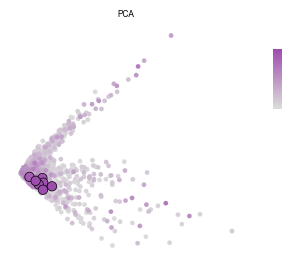

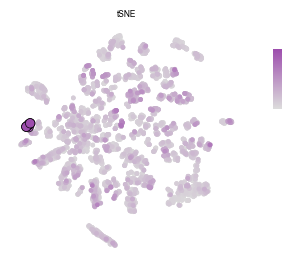

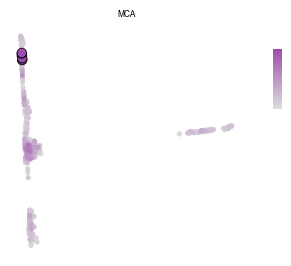

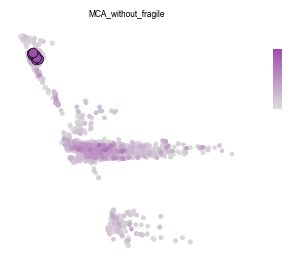

In [31]:
bonf = -np.log10(0.05 / 940)

for label in ['PCA', 'tSNE', 'MCA', 'MCA_without_fragile']:
    fig, ax = plt.subplots(1, figsize=(3, 3))
    
    metric = label
    
    plot_data = nbl_noncoding_results.sort_values(by = 'negative_log10_p_value', ascending = True)
    
    if metric == "MCA_without_fragile":
        plot_data = plot_data[~plot_data['category'].str.contains('fragile_site')]
        metric = 'MCA'

    index = 0
    while index < len(data):

        subdata = plot_data.iloc[index:index + 200, :]
        sizes = subdata['bonferroni_significant'].fillna(False).replace({False: 2, True: 4})
        linewidths = subdata['bonferroni_significant'].fillna(False).replace({False: 0, True: 0.5})
        edgecolors = subdata['bonferroni_significant'].fillna(False).replace({False: 'none', True: 'black'})

        points = sns.scatterplot(
            x=f"{metric}_1",
            y=f"{metric}_2",
            data=subdata,
            ec=edgecolors,
            hue='negative_log10_p_value',
            hue_norm = norm,
            size= sizes,
            linewidth=linewidths,
            palette=custom_cmap,
            ax=ax,
            label=''
        )

        index += 200

    ax.legend().remove()

    # add the colorbar
    cb = matplotlib.cm.ScalarMappable(norm=norm, cmap=custom_cmap)

    cbar_ax = fig.add_axes([1, 0.6, 0.03, 0.2])
    cbar = fig.colorbar(cb, cax=cbar_ax, orientation='vertical')

    cbar.ax.tick_params(size=0)
    cbar.set_ticklabels([])
    cbar.outline.set_visible(False)

    aesthetics.strip_axis(ax)
    
    ax.set_title(label)
    
    fig.savefig(f'images/{label}-nbl-noncoding-categories.png', dpi = 600, bbox_inches = 'tight')

In [36]:
cat_data = data.copy()
cat_data_values = cat_data.values

<AxesSubplot:xlabel='category', ylabel='category'>

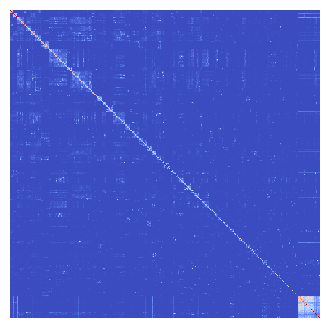

In [37]:
j_dist = pdist(cat_data_values, metric="jaccard")
j_dist = 1 - squareform(j_dist)

Z = linkage(j_dist, method="average")
ordered_indices = leaves_list(Z)
j_dist = j_dist[ordered_indices, :][:, ordered_indices]
j_dist = pd.DataFrame(
    j_dist, index=cat_data.index[ordered_indices], columns=cat_data.index[ordered_indices]
)

fig, ax = plt.subplots(1, figsize=(4, 4))
sns.heatmap(j_dist, annot=False, cmap="coolwarm", cbar=False)
aesthetics.strip_axis(ax=ax)

# ax.set_title(
#     "Jaccard similarity between bonferroni significant categories", fontsize=12
# )
# fig.savefig(
#     f"data/cwas-results/{disease}-jaccard-similarity-between-categories.png",
#     bbox_inches="tight",
# )